In [55]:
import pandas as pd
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import confusion_matrix, f1_score, precision_score,\
recall_score, confusion_matrix, classification_report, accuracy_score 
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from scipy import stats

Split train test, use train set to tune parameters (kfold cross validation), we don't have enough data for validation set
*Note: no need to scale anything, features are on the same scale!

Ensemble classfier won't work because the classifers in our case does not produce results that compensate each other, so we can adopt svm only

Result analysis:
We analysis the valence day frequency in the train test set and the prediction results
in the ValenceVector2.ipyn file, we already show that the differences of valence days. (In general, low group has slightly more empty days, less negative days, less positive days and less mixed days. The two groups are significantly different in negative days from 60 days 30 days and 10 days, the p value is getting smaller as the time is close to the time they fill out the CES-D scale. There are no significant difference found in positive valence and  neutral. Mix days are significantly different in 10 days)

We check the train test split has similar statistics as the whole sample. 
*Note: the difference are not significant in the test set because the test set has 24 cases only

In our test result from SVM, low group has more empty days, less negative days, less positive days, less mixed days. Therefore, the svm classifier is able to capture the features in the sample.

*Note: the classifers are not good in class 0 (non-depressed). The 10 days vector has been shown to have more significant differences, however, the 10 days feature perfrom badly in the classification, probably because our sample size is too small, less features won't help the classification. 

This part will need to be rerun after the new annotations are ready.




In [10]:
#merge with CESD
cesd = pd.read_csv('../important_data/adjustedCESD.csv')
cesdSum = cesd[['userid','cesd_sum']]
valenceVec = pd.read_csv('../important_data/ValenceVec_Norm_Mix.csv')
ValCesd = pd.merge(valenceVec, cesdSum, how = 'left', on ='userid')
#remove duplicate
ValCesd = ValCesd.drop_duplicates(subset='userid', keep="first")
ValCesd.shape

(77, 62)

In [66]:
y = ValCesd["cesd_sum"]
X = ValCesd.iloc[:,1:61]
def recode(array):
    new = []
    for num in array:
        if num <= 23:
            new.append(0)
        if num > 23:
            new.append(1)
    return new
        
y = recode(y)
print(y.count(1))
print(y.count(0))

41
36


In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state = 300)
cv = StratifiedKFold(n_splits=3, random_state = 0)
svc = make_pipeline(svm.SVC())
parameters = [{'svc__kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'svc__gamma': [0.5,0.1, 0.01,0.001, 0.0001],
                     'svc__C':[0.1, 0.3, 0.5, 0.7, 0.9, 1.0, 1.5, 2.0, 10] , 'svc__class_weight':['balanced']}]

grid_search_item = GridSearchCV(svc,
                          param_grid = parameters,
                           cv = cv,
                           scoring = 'accuracy',
                           n_jobs = -1)
grid_searchSVC = grid_search_item.fit(X_train, y_train)

print(grid_searchSVC.best_score_)
print(grid_searchSVC.best_params_)

means = grid_searchSVC.cv_results_['mean_test_score']
stds = grid_searchSVC.cv_results_['std_test_score']
params = grid_searchSVC.cv_results_['params']

y_true, y_predSvm = y_test, grid_searchSVC.predict(X_test)
print(classification_report(y_true, y_predSvm))

0.6792452830188679
{'svc__C': 2.0, 'svc__class_weight': 'balanced', 'svc__gamma': 0.01, 'svc__kernel': 'sigmoid'}
              precision    recall  f1-score   support

           0       0.60      0.67      0.63         9
           1       0.79      0.73      0.76        15

   micro avg       0.71      0.71      0.71        24
   macro avg       0.69      0.70      0.70        24
weighted avg       0.72      0.71      0.71        24



/Users/lucia/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


[0.         0.33333333 1.        ] [0.         0.73333333 1.        ] [2 1 0]


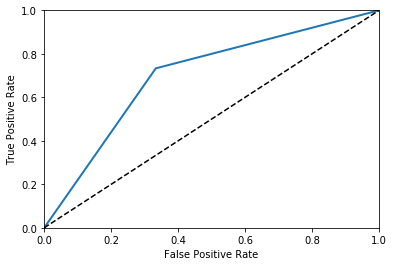

In [38]:
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
print(fpr, tpr, thresholds)
def plot_roc_curve(fpr, tpr, label=None): 
    plt.plot(fpr, tpr, linewidth=2, label=label) 
    plt.plot([0, 1], [0, 1], 'k--') 
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate') 
    plt.ylabel('True Positive Rate')
plot_roc_curve(fpr, tpr) 
plt.show()

In [7]:
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier()
parameters = [{'max_depth': [1,2,3,4,5], 'n_estimators': [50,100,150,200],
                     'learning_rate':[1.0, 1.5, 2.0, 2.5, 3.0],'random_state':[100]}]
grid_search_item = GridSearchCV(gbc,
                          param_grid = parameters,
                           cv = cv,
                           scoring = 'accuracy',
                           n_jobs = -1)
grid_search = grid_search_item.fit(X_train, y_train)

print(grid_search.best_score_)
print(grid_search.best_params_)

means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
params = grid_search.cv_results_['params']

y_true, y_pred = y_test, grid_search.predict(X_test)
print(classification_report(y_true, y_pred))

0.6037735849056604
{'learning_rate': 1.0, 'max_depth': 4, 'n_estimators': 50, 'random_state': 100}
              precision    recall  f1-score   support

           0       0.38      0.56      0.45         9
           1       0.64      0.47      0.54        15

   micro avg       0.50      0.50      0.50        24
   macro avg       0.51      0.51      0.50        24
weighted avg       0.54      0.50      0.51        24



/Users/lucia/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [41]:
from sklearn import model_selection
from sklearn.ensemble import AdaBoostClassifier
Ada = AdaBoostClassifier()
parameters = [{'algorithm': ['SAMME', 'SAMME.R'], 'n_estimators': [50,100,150,200],
                     'learning_rate':[1.0, 1.5, 2.0, 2.5, 3.0],'random_state':[100]}]

grid_search_item = GridSearchCV(Ada,
                          param_grid = parameters,
                           cv = cv,
                           scoring = 'accuracy',
                           n_jobs = -1)
grid_search = grid_search_item.fit(X_train, y_train)

print(grid_search.best_score_)
print(grid_search.best_params_)

means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
params = grid_search.cv_results_['params']

y_true, y_pred = y_test, grid_search.predict(X_test)
print(classification_report(y_true, y_pred))


0.6226415094339622
{'algorithm': 'SAMME.R', 'learning_rate': 2.5, 'n_estimators': 50, 'random_state': 100}
              precision    recall  f1-score   support

           0       0.33      0.56      0.42         9
           1       0.56      0.33      0.42        15

   micro avg       0.42      0.42      0.42        24
   macro avg       0.44      0.44      0.42        24
weighted avg       0.47      0.42      0.42        24



/Users/lucia/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [45]:
#emsemble voting
estimators = []
model3 = svm.SVC(C = 2.0, kernel  = 'sigmoid', gamma =0.01,class_weight = 'balanced', random_state=300)
estimators.append(('svm', model3))
model1 = GradientBoostingClassifier(max_depth= 4, learning_rate= 1.0, n_estimators= 50, random_state= 100)
estimators.append(('gbc', model1))
# model2 = AdaBoostClassifier(algorithm= 'SAMME.R', learning_rate= 2.5, n_estimators= 50, random_state= 100)
# estimators.append(('ada', model2))

ensemble = VotingClassifier(estimators)
eclf1 = ensemble.fit(X_train, y_train)
y_pred = eclf1.predict(X_test)
print('ROC is {}'. format(roc_auc_score(y_test, y_pred)))
print(classification_report(y_test, y_pred))
confusion_matrix(y_test, y_pred)


ROC is 0.5888888888888888
              precision    recall  f1-score   support

           0       0.44      0.78      0.56         9
           1       0.75      0.40      0.52        15

   micro avg       0.54      0.54      0.54        24
   macro avg       0.59      0.59      0.54        24
weighted avg       0.63      0.54      0.54        24



array([[7, 2],
       [9, 6]])

Ensemble classfier won't work because the classifers in our case does not produce results that compensate each other, so we can adopt svm only

Let's see what features the classifer capture
First we see what our train test set look like

Test set

In [ ]:
def VectorStats(df):
    given_set = {-1}
    given_set1 = {1}
    given_set2 = {2}
    given_set4 = {4}
    given_set3 = {3}
    df['empty']= df.isin(given_set).sum(1)
    df['negative']= df.isin(given_set1).sum(1)
    df['positive']= df.isin(given_set2).sum(1)
    df['neutral']= df.isin(given_set4).sum(1)
    df['mix']= df.isin(given_set3).sum(1)
    print('empty days in this group {}'.format(df['empty'].describe()))
    print('negative days in this group {}'.format(df['negative'].describe()))
    print('positive days in this group {}'.format(df['positive'].describe()))
    print('neutral days in this group {}'.format(df['neutral'].describe()))
    print('mix days in this group {}'.format(df['mix'].describe()))

# high_30 = OneMonthVec.loc[OneMonthVec['biLabel'] == 1, ]
# VectorStats(high_30)

In [48]:
#select cases in the test set
indexes = X_test.index.values
ValCesd['biLabel'] = y
TestFea = ValCesd.loc[indexes]


,userid,0,1,2,3,4,5,6,7,8,...,52,53,54,55,56,57,58,59,cesd_sum,biLabel
90,0e3fdb89c7706b13891170ab2a9017c7,2,1,-1,2,1,1,2,-1,-1,...,2,4,-1,-1,-1,-1,-1,-1,4,0
79,23cbbe03a89344129e1a6d8419a66d23,-1,-1,-1,-1,-1,-1,1,-1,1,...,2,-1,2,2,2,2,2,2,28,1
12,e9970fe8848e9505b52d414d81611de8,2,-1,-1,-1,-1,4,-1,-1,4,...,-1,-1,-1,-1,-1,-1,-1,-1,34,1
65,4764518d32334248e6ebbf681a18fd0c,4,4,-1,2,2,4,1,1,-1,...,2,1,2,4,-1,-1,1,1,23,0


In [51]:
high = TestFea.loc[TestFea['biLabel'] == 1, ]
VectorStats(high)

empty days in this group count    15.000000
mean     31.200000
std       6.678323
min      15.000000
25%      28.500000
50%      33.000000
75%      35.500000
max      40.000000
Name: empty, dtype: float64
negative days in this group count    15.000000
mean      8.866667
std       4.290632
min       4.000000
25%       5.500000
50%       8.000000
75%      11.500000
max      19.000000
Name: negative, dtype: float64
positive days in this group count    15.000000
mean     14.533333
std       3.979710
min       8.000000
25%      11.500000
50%      15.000000
75%      17.000000
max      21.000000
Name: positive, dtype: float64
neutral days in this group count    15.000000
mean      5.866667
std       3.377799
min       0.000000
25%       3.500000
50%       6.000000
75%       8.500000
max      12.000000
Name: neutral, dtype: float64
mix days in this group count    15.000000
mean      0.866667
std       0.833809
min       0.000000
25%       0.000000
50%       1.000000
75%       1.000000
max     

/Users/lucia/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/Users/lucia/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/lucia/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

In [52]:
low = TestFea.loc[TestFea['biLabel'] == 0, ]
VectorStats(low)

/Users/lucia/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/Users/lucia/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/lucia/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

empty days in this group count     9.000000
mean     37.000000
std      11.146748
min      12.000000
25%      36.000000
50%      37.000000
75%      42.000000
max      53.000000
Name: empty, dtype: float64
negative days in this group count     9.000000
mean      6.888889
std       4.284987
min       1.000000
25%       4.000000
50%       6.000000
75%       9.000000
max      15.000000
Name: negative, dtype: float64
positive days in this group count     9.000000
mean     11.444444
std       6.765928
min       1.000000
25%       8.000000
50%       9.000000
75%      19.000000
max      20.000000
Name: positive, dtype: float64
neutral days in this group count     9.000000
mean      4.333333
std       3.640055
min       0.000000
25%       2.000000
50%       5.000000
75%       6.000000
max      12.000000
Name: neutral, dtype: float64
mix days in this group count    9.000000
mean     0.666667
std      0.707107
min      0.000000
25%      0.000000
50%      1.000000
75%      1.000000
max      2.0000

/Users/lucia/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


In [56]:
def ttest(high, low):
    print('compare empty days {}'. format(stats.ttest_ind(high['empty'], low['empty'])))
    print('compare negative days {}'. format(stats.ttest_ind(high['negative'], low['negative'])))
    print('compare positive days {}'. format(stats.ttest_ind(high['positive'], low['positive'])))
    print('compare neutral days {}'. format(stats.ttest_ind(high['neutral'], low['neutral'])))
    print('compare mix days {}'. format(stats.ttest_ind(high['mix'], low['mix'])))
ttest(high, low)

compare empty days Ttest_indResult(statistic=-1.6038275245863756, pvalue=0.12301316971052453)
compare negative days Ttest_indResult(statistic=1.0937680452942726, pvalue=0.2858885371803433)
compare positive days Ttest_indResult(statistic=1.4171069928531999, pvalue=0.1704584244181032)
compare neutral days Ttest_indResult(statistic=1.046372128455853, pvalue=0.3067502276103799)
compare mix days Ttest_indResult(statistic=0.6003639672764213, pvalue=0.5543984940388119)


Nothing is significantly different in the test sample
Now let's see the train set

In [59]:
#select cases in the test set
indexes = X_train.index.values
trainFea = ValCesd.loc[indexes]

In [64]:
high = trainFea.loc[trainFea['biLabel'] == 1, ]
VectorStats(high)

/Users/lucia/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/Users/lucia/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/lucia/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

empty days in this group count    26.000000
mean     27.038462
std      14.801299
min       1.000000
25%      20.250000
50%      29.000000
75%      37.000000
max      57.000000
Name: empty, dtype: float64
negative days in this group count    26.000000
mean     11.961538
std       7.701848
min       1.000000
25%       8.000000
50%      11.000000
75%      15.500000
max      40.000000
Name: negative, dtype: float64
positive days in this group count    26.000000
mean     16.038462
std      11.714882
min       0.000000
25%      10.250000
50%      12.500000
75%      20.000000
max      47.000000
Name: positive, dtype: float64
neutral days in this group count    26.000000
mean      5.576923
std       2.941742
min       1.000000
25%       4.000000
50%       5.000000
75%       8.000000
max      13.000000
Name: neutral, dtype: float64
mix days in this group count    26.000000
mean      0.615385
std       1.328967
min       0.000000
25%       0.000000
50%       0.000000
75%       0.750000
max     

/Users/lucia/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


In [63]:
low = trainFea.loc[trainFea['biLabel'] == 0, ]
VectorStats(low)

/Users/lucia/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/Users/lucia/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/lucia/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

empty days in this group count    27.000000
mean     28.259259
std      12.330677
min       0.000000
25%      22.000000
50%      28.000000
75%      36.500000
max      59.000000
Name: empty, dtype: float64
negative days in this group count    27.000000
mean      8.000000
std       4.332347
min       0.000000
25%       4.000000
50%       8.000000
75%      12.000000
max      15.000000
Name: negative, dtype: float64
positive days in this group count    27.000000
mean     17.481481
std       9.333028
min       1.000000
25%      12.000000
50%      15.000000
75%      20.000000
max      44.000000
Name: positive, dtype: float64
neutral days in this group count    27.000000
mean      6.111111
std       4.388213
min       0.000000
25%       2.500000
50%       6.000000
75%       9.000000
max      14.000000
Name: neutral, dtype: float64
mix days in this group count    27.000000
mean      0.629630
std       0.741524
min       0.000000
25%       0.000000
50%       0.000000
75%       1.000000
max     

/Users/lucia/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


In [65]:
ttest(high, low)

compare empty days Ttest_indResult(statistic=-0.326738412106534, pvalue=0.7452029492520422)
compare negative days Ttest_indResult(statistic=2.319212330198177, pvalue=0.024425955011303062)
compare positive days Ttest_indResult(statistic=-0.49695195387525226, pvalue=0.6213585019006429)
compare neutral days Ttest_indResult(statistic=-0.5184971867566572, pvalue=0.6063538708143157)
compare mix days Ttest_indResult(statistic=-0.04842680423941222, pvalue=0.9615652494175815)


only negative valence is significantly different
Now let's see the prediction result

In [73]:
TestFea['preLabel'] = y_predSvm


In [75]:
#high group
preHigh = TestFea.loc[TestFea['preLabel'] == 1, ]
VectorStats(preHigh)

/Users/lucia/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/Users/lucia/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/lucia/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

empty days in this group count    14.000000
mean     31.571429
std       6.548215
min      15.000000
25%      30.000000
50%      32.500000
75%      35.500000
max      42.000000
Name: empty, dtype: float64
negative days in this group count    14.000000
mean      9.642857
std       4.465373
min       5.000000
25%       6.250000
50%       9.000000
75%      12.000000
max      20.000000
Name: negative, dtype: float64
positive days in this group count    14.000000
mean     14.357143
std       4.829511
min       6.000000
25%      10.250000
50%      15.000000
75%      19.000000
max      21.000000
Name: positive, dtype: float64
neutral days in this group count    14.000000
mean      5.642857
std       2.619664
min       2.000000
25%       3.250000
50%       5.500000
75%       6.750000
max      10.000000
Name: neutral, dtype: float64
mix days in this group count    14.000000
mean      0.857143
std       0.949262
min       0.000000
25%       0.000000
50%       1.000000
75%       1.000000
max     

In [76]:
preLow = TestFea.loc[TestFea['preLabel'] == 0, ]
VectorStats(preLow)

empty days in this group count    10.00000
mean     35.90000
std      11.25907
min      12.00000
25%      35.25000
50%      37.50000
75%      41.50000
max      53.00000
Name: empty, dtype: float64
negative days in this group count    10.000000
mean      7.400000
std       4.195235
min       1.000000
25%       4.500000
50%       7.500000
75%       9.000000
max      15.000000
Name: negative, dtype: float64
positive days in this group count    10.000000
mean     12.000000
std       5.830952
min       1.000000
25%       9.000000
50%      11.500000
75%      16.750000
max      20.000000
Name: positive, dtype: float64
neutral days in this group count    10.000000
mean      4.500000
std       4.478343
min       0.000000
25%       1.250000
50%       3.500000
75%       5.750000
max      12.000000
Name: neutral, dtype: float64
mix days in this group count    10.000000
mean      0.800000
std       0.632456
min       0.000000
25%       0.250000
50%       1.000000
75%       1.000000
max       2.0000

/Users/lucia/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/Users/lucia/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/lucia/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

In [77]:
ttest(preHigh, preLow)

compare empty days Ttest_indResult(statistic=-1.189880830547892, pvalue=0.24677612177139144)
compare negative days Ttest_indResult(statistic=1.2433221664927563, pvalue=0.2268363375617889)
compare positive days Ttest_indResult(statistic=1.0818588502808761, pvalue=0.29103165993002766)
compare neutral days Ttest_indResult(statistic=0.7883330048613166, pvalue=0.4389145234469928)
compare mix days Ttest_indResult(statistic=0.16541820963727633, pvalue=0.8701254725500155)
